# BATS climatologies 

The objective of the present notebook is to display the climatologies generated for the BATS station in the frame of the SEAMLESS project for the purpose of initialisation and overview of local dynamics. 

The steps involves : 
1. Loading the files generated in gotm-friendly formats. 
2. Integrate the data in an xarray structure
3. Make some plots
4. Output netcdf equivalent to these files, for any type of later usage. 

We assume the climatology files have been produced using  `python reader_bats_bottle.py` 

In [90]:
# System setup and user definitions
from matplotlib import pyplot as plt
import datetime as dt
import numpy as np
import xarray as xr

filedir = './GOTM_INPUT_CLIM/'
varlist = ['Temp', 'Sal1','NOX'       , 'PO41'   ,'O2'       ,'CO2'     , 'Alk'   ,'Si1','POC','PON','POP']
# AC 15.09.2021 : Paolo, please check the units.
units= {'Temp':'°C',
        'Sal1':'-',
        'NOX':'mmolN/m3',
        'PO41':'mmolP/m3',
        'O2':'mmolO2/m3',
        'CO2':'mmolC/m3',
        'Alk':'mmol/m3',
        'Si1':'mmolSi/m3',
        'POC':'mmolC/m3',
        'PON':'mmolN/m3',
        'POP':'mmolP/m3'}

In [2]:
# AC 15.09.2021 This can be removed if O2_clim.txt is generated instead of 'O2(1)_clim.txt', which is a strange filename
import os
os.system("mv '"+ filedir+"O2(1)_clim.txt' "+filedir+"O2_clim.txt")

mv: cannot stat './GOTM_INPUT_CLIM/O2(1)_clim.txt': No such file or directory


256

In [91]:
def gotm_to_xr(var, units,filedir=filedir):
    '''
    Read and load GOTM-friendly files into xarray structure.
    A. Capet 15/09/2021
    
    Parameters
    ----------
    var : str
        name of a variable. Should correspond to a 'var'_clim.txt file in filedir
    filedir : str
        directory for the climatology files
                
    Returns    
    ----------
    An xarray with the variable var
    '''
    
    fn=filedir+var+'_clim.txt'

    with open(fn) as f:
        tcount=0
        while True:
            txt = f.readline()
            if not txt:
                break
            date,nrow,_=txt.split('\t')
            npa=np.empty([int(nrow),2])
            for n in range(int(nrow)):
                d,v = f.readline().split('\t')
                npa[n,:]=[float(d),float(v)]
            xrl=xr.DataArray(npa[:,1],coords={"depth":npa[:,0]}, dims=['depth'])
            xrl=xrl.expand_dims({"time":[np.datetime64(date)]})
            if tcount==0:
                xrlo=xrl.copy()
            else:
                xrlo=xr.concat([xrlo, xrl],dim="time")
            tcount+=1

    xrlo.attrs["units"] = units[var]
    xrd=xr.Dataset({var:xrlo})
    
    return(xrd)
    
def gotm_clim_load(varlist,filedir,units):
    '''
    Read and load GOTM-friendly files into xarray structure.
    A. Capet 15/09/2021
    
    Parameters
    ----------
    varlist : list of str
        list of variable names. Each should correspond to a 'var'_clim.txt file in filedir
    filedir : str
        directory for the climatology files
    units : dict
        associate units (str) to each var of varlist
                
    Returns    
    ----------
    An xarray dataset with all variables
    '''
    xs = [gotm_to_xr(v,units,filedir) for v in varlist]
    
    xs = xr.merge(xs)
    return(xs)

In [92]:
xrN=gotm_clim_load(varlist,filedir,units)

xrN

<xarray.Dataset>
Dimensions:  (depth: 39, time: 12)
Coordinates:
  * depth    (depth) float64 -1.098e+04 -4.2e+03 -4e+03 ... -20.0 -10.0 -0.0
  * time     (time) datetime64[ns] 2014-01-16T12:00:00 ... 2014-12-16T12:00:00
Data variables:
    Temp     (time, depth) float64 2.211 2.211 2.218 2.237 ... 22.77 22.78 22.63
    Sal1     (time, depth) float64 34.88 34.88 34.89 34.89 ... 36.63 36.62 36.65
    NOX      (time, depth) float64 20.44 20.44 20.17 ... 0.005213 0.0 0.005214
    PO41     (time, depth) float64 1.361 1.361 1.329 1.303 ... 0.0 0.0 0.0 0.0
    O2       (time, depth) float64 275.2 275.2 276.4 277.9 ... 222.6 221.8 222.9
    CO2      (time, depth) float64 2.738e+04 2.738e+04 ... 2.574e+04 2.575e+04
    Alk      (time, depth) float64 2.444e+03 2.444e+03 ... 2.498e+03 2.497e+03
    Si1      (time, depth) float64 37.16 37.16 35.42 ... 0.8289 0.8185 0.7456
    POC      (time, depth) float64 0.0 nan nan nan ... 23.79 23.51 23.65 23.0
    PON      (time, depth) float64 0.0 nan nan nan ... 0.3083 0.3381 0.2886
    POP      (time, depth) float64 0.0 nan nan ... 0.0002354 0.0002354 0.0003364

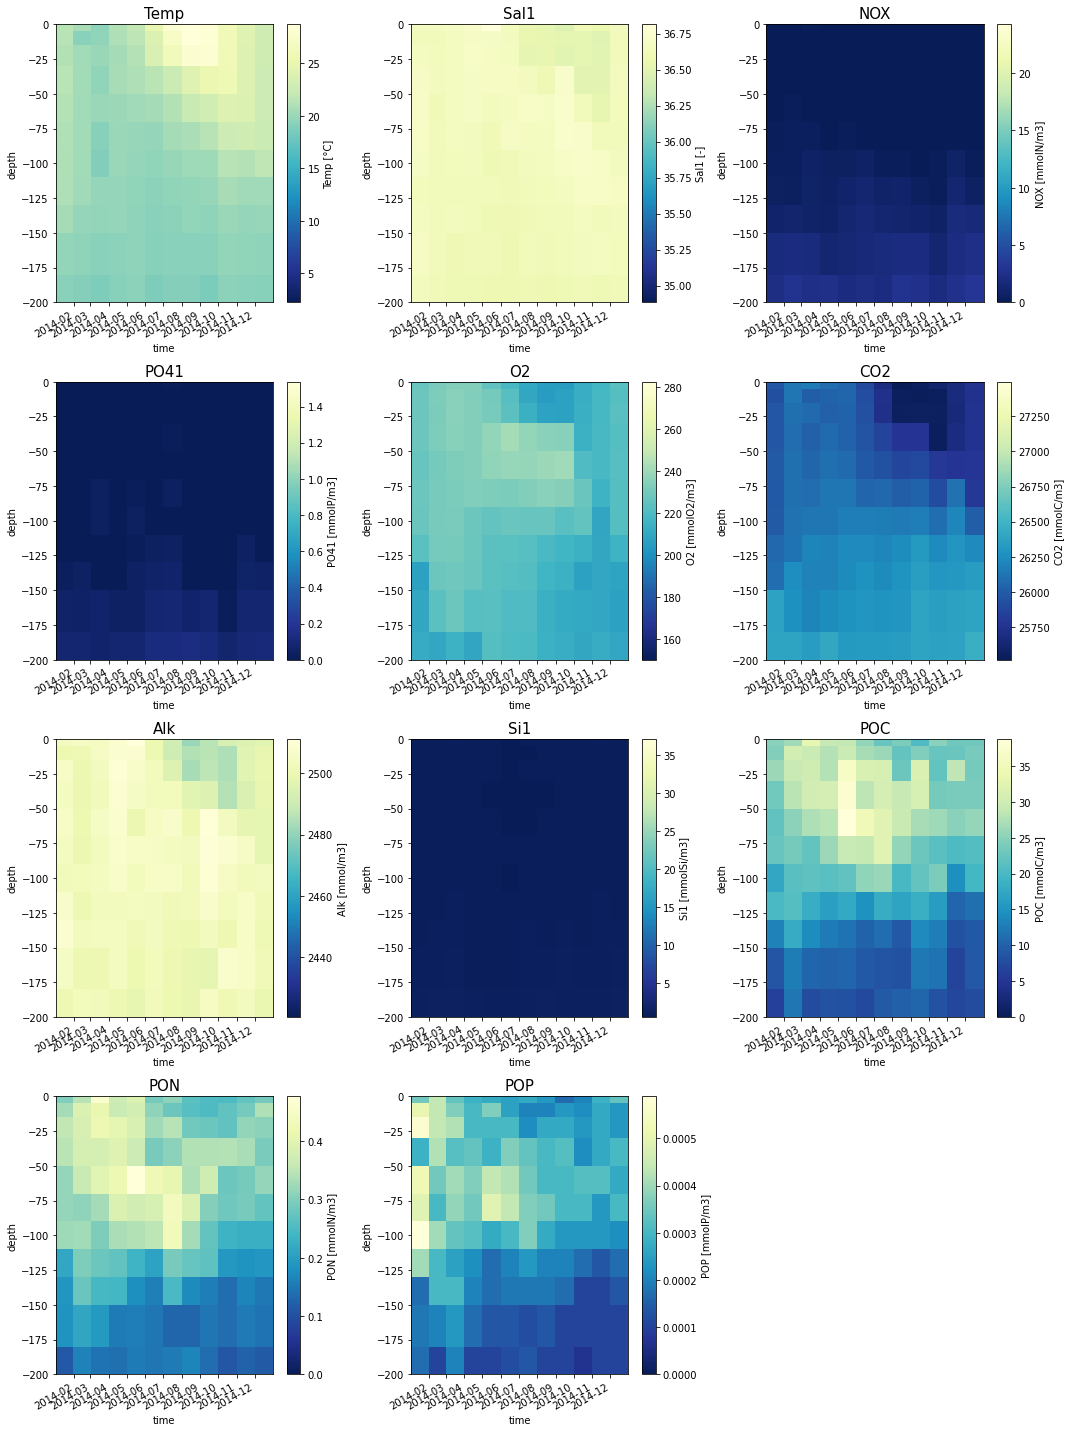

In [115]:
###########
ncolplot=3
ylim =-200
###########

nrowplot=int(np.ceil(len(varlist)/ncolplot))

f=plt.figure(figsize=(ncolplot*5,nrowplot*5))
for i,v in enumerate(varlist) : 
    ax=f.add_subplot(nrowplot,ncolplot,i+1)
    xrN[v].plot(x='time',y='depth', ylim=[-200,0], ax=ax, cmap='YlGnBu_r')
    ax.set_title(v, fontsize=15)
f.tight_layout()

plt.savefig(filedir+'BatsClims.png', facecolor='white')

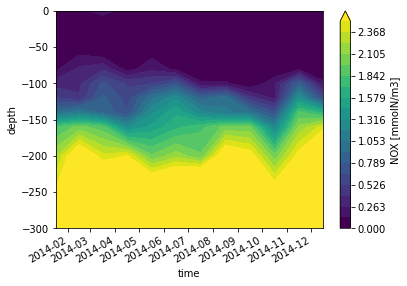

In [102]:
# Some examples
_=xrN.NOX.plot.contourf(x='time',y='depth', ylim=[-300,0], vmax=2.5, levels=20)

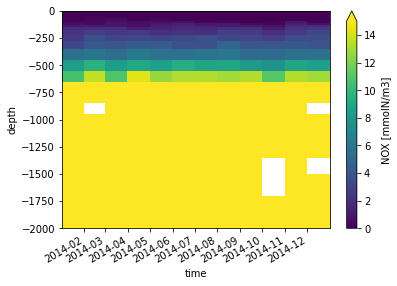

In [106]:
# Some examples
_=xrN.NOX.plot(x='time',y='depth', ylim=[-2000,0], vmax=15)

In [107]:
# Netcdf export
xrN.to_netcdf(filedir+'BATS_CLIM.nc')